https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn

In [ ]:
import argparse
import os 
import csv
import wandb
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from timm import optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import models
import timm
from torch.utils.data import DataLoader, WeightedRandomSampler, default_collate
import random
from tqdm import tqdm
import time

from Dataset_ML import *
from utils_ML import *

from LUV_NET_TFWO import *
from LUV_NET import *

from cnnlstm import CNNLSTM
from C3D_model import C3D
from R2Plus1D_model import R2Plus1DClassifier

import vidaug.augmentors as va

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve

import math
from sklearn.preprocessing import OneHotEncoder

In [2]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)

In [3]:
pwd

'/home/hoon2/LUS/code/pda_detection/code'

In [4]:
def models_output_to_dataframe(df, model_name, labels, model_output):
    """
    모델 출력을 기존 데이터프레임에 추가하는 함수
    """
    temp_df = pd.DataFrame(model_output, columns=labels)
    temp_df.columns = [f'{model_name}_{label}' for label in labels]
    
    if df.empty:
        return temp_df
    else:
        return pd.concat([df, temp_df], axis=1)

In [ ]:
# def collate_video(batch_list):
#     """
#     A custom collate function to be passed to the callate_fn argument when creating a pytorch dataloader.
#     This is necessary because videos have different lengths. We handle by combining all videos along the time 
#     dimension and returning the number of frames in each video.
#     """
#     vids = torch.concat([b[0] for b in batch_list])
#     # num_frames = [b.shape[0] for b in batch_list]
#     labels = [b[1] for b in batch_list]
#     # record = {
#     #     'video': vids,
#     #     'num_frames': num_frames
#     # }

#     # use pytorch's default collate function for remaining items
#     # for b in batch_list:
#     #     b.pop('video')
#     # record.update(default_collate(batch_list))

#     return vids, labels

def collate_video(batch_list):
    """
    A custom collate function to be passed to the callate_fn argument when creating a pytorch dataloader.
    This is necessary because videos have different lengths. We handle by combining all videos along the time 
    dimension and returning the number of frames in each video.
    """
    vids = torch.concat([b[0] for b in batch_list])
    # num_frames = [b.shape[0] for b in batch_list]
    labels = [b[1] for b in batch_list]
    paths = [b[2] for b in batch_list]

    return vids, labels, paths

def test(model_test_rate, version, img_size, model_output_class, model_name, num_heads, kernel_size, encoder_name, train_layer, pooling_method, weight_path, base_path, fold_num, batch_size, is_train=False):
    
    test_csv_path = os.path.join(base_path, f'clip/{model_output_class}_artifacts/temporally_separated_test.csv')

    # dataset
    test_dataset = video_dataset(test_csv_path, transforms = apply_transforms(mode=None), img_size = img_size, is_train = False)
    
    if model_name == 'LUV_Net' or model_name == 'LUV_Net_TFWO':
        # dataloader
        test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False, collate_fn=collate_video, drop_last=False)
    
    #len_dataloader
    len_test_dataset = len(test_dataloader.dataset)
    print(len_test_dataset)
    # set seed
    set_all_seeds(1234)
    if model_name == 'LUV_Net' or model_name == 'LUV_Net_TFWO':
        if encoder_name == 'densenet161':
            encoder = timm.create_model('densenet161', pretrained=False, num_classes=0)
        elif encoder_name == 'imgnet_init_densenet161':
            encoder = timm.create_model('densenet161', pretrained=False, num_classes=0)
        elif encoder_name == 'densenet161_scratch':
            encoder = timm.create_model('densenet161', pretrained=False, num_classes=0)
        elif encoder_name == 'imgnet_init_resnet50':
            encoder = timm.create_model('resnet50', pretrained=False, num_classes=0)
        elif encoder_name == 'resnet50_scratch':
            encoder = timm.create_model('resnet50', pretrained=False, num_classes=0)
            
    elif model_name == 'CNNLSTM':
        if encoder_name == 'densenet161':
            encoder = timm.create_model('densenet161', pretrained=False)
            
        elif encoder_name == 'imgnet_init_densenet161':
            encoder = timm.create_model('densenet161', pretrained=True)
        
    simoid = nn.Sigmoid()
    
    # Set up model
    if model_name == 'LUV_Net':
#         num_heads = 32
        num_frames = [30]*batch_size
        
        model = LUV_Net(encoder, num_heads, pooling_method = pooling_method, kernel_width= kernel_size)
    
    elif model_name == 'LUV_Net_TFWO':
        num_frames = [30]*batch_size
        
        model = LUV_Net_TFWO(encoder, num_heads, pooling_method = pooling_method)
        
    
    gpu_index = 3
    device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

    check_point = torch.load(weight_path, map_location=device)
    # torch.nn.DataParallel을 사용하여 모델을 학습하고 저장한 경우에 이러한 접두어가 자주 발생
    if 'module' in list(check_point['model'].keys())[0]:
        # If so, remove the 'module.' prefix from the keys in the state_dict
        new_state_dict = {k[7:]: v for k, v in check_point['model'].items()}
        model.load_state_dict(new_state_dict)
    else:
        # If not using DataParallel, simply load the state_dict
        model.load_state_dict(check_point['model'])
    
    model = model.to(device)
    
    # load best threshold
    best_val_thres = check_point['best_valid_thres']
    print(best_val_thres)
    # list
    model_outputs = []
    test_labels = []
    test_preds = []
    
    test_paths_lst = []
    
    #acc
    test_running_acc = 0.0
    
    model.eval() 
    with torch.no_grad():    
            
#         for jdx, data in enumerate(test_dataloader):
        for data in tqdm(test_dataloader, desc="Testing", unit="batch"):    
            test_img, test_label, test_paths = data
            
            test_img = test_img.float().to(device)
            test_label = torch.stack([label.to(device) for label in test_label])
            
            test_output, attentions = model(test_img, num_frames)
                
            test_output = simoid(test_output)
            model_outputs.append(test_output[0].cpu().detach().numpy().tolist())
        
            test_preds_np = test_output[0].data.cpu().numpy()
            
            test_preds_np = np.where(test_preds_np >= best_val_thres, 1, 0)
#             test_preds_np = np.where(test_preds_np >= 0.5, 1, 0)
            
            test_preds.append(test_preds_np.tolist())
#             print(test_label.shape)
#             print(test_label[0].shape)
            test_labels.append(test_label[0].detach().cpu().numpy().tolist())
            
            np_test_label = test_label[0].cpu().numpy()
#             print(np_test_label.shape)
#             print(test_preds_np.shape)
            test_accuracy = accuracy_score(np_test_label, test_preds_np)
            
            test_running_acc += test_accuracy
            
            test_paths_lst.append(test_paths[0])
#             print(f"prediction : {test_preds_np}, test_label : {np_test_label}")
#             print(f"correct_num : {test_accuracy}")
#             print('-'*20)
            
    test_accuracy = test_running_acc / len_test_dataset
    print(f"test_running_acc : {test_running_acc}")
    
    return test_accuracy, test_labels, test_preds, model_outputs, test_paths_lst

In [6]:
pwd

'/home/hoon2/LUS/code/pda_detection/code'

In [ ]:
fold_num = 0

model_name = 'LUV_Net'
pooling_method = 'attn_multilabel_conv'

# model_name = 'LUV_Net_TFWO'
# pooling_method = 'attn_multilabel_conv'

# pooling_method = 'max'
# pooling_method = 'avg'

chk_std = "loss"
# chk_std = "auc"

version = 'version_1'
train_layer = 'all'
# train_layer = 'pooling'

# encoder_name = 'densenet161'
# encoder_name = 'imgnet_init_densenet161'
encoder_name = 'densenet161_scratch'

# encoder_name = 'imgnet_init_resnet50'

model_test_rate = "0.2"

encoder_batch_size = 32
# encoder_batch_size = 128

batch_size = 4
# batch_size = 8

lr = '1e-06'

# model_output_class = 4
model_output_class = 5

# head_num = 1
# head_num = 2
# head_num = 4
head_num = 8
# head_num = 16
# head_num = 32
# head_num = 96

k_size = 13

img_size = 256

weight_path = f'/data2/hoon2/Results/video_model2/seed234_test{model_test_rate}_std_{chk_std}_{version}_{train_layer}_{model_output_class}_artifacts_duplicate_batch{batch_size}_256_30frame_{model_name}_{encoder_name}_{encoder_batch_size}_{pooling_method}_{head_num}head_{k_size}ksize_fold{fold_num}_lr{lr}_checkpoint'
# weight_path = f'/data2/hoon2/Results/video_model2/seed34_test{model_test_rate}_std_{chk_std}_{version}_{train_layer}_{model_output_class}_artifacts_duplicate_batch{batch_size}_256_30frame_{model_name}_{encoder_name}_{encoder_batch_size}_{pooling_method}_{head_num}head_{k_size}ksize_fold{fold_num}_lr{lr}_checkpoint'

base_path = f'/data2/hoon2/LUS_Dataset/csv_files/temporally_separated_test_set'

is_train = False

392
[np.float32(0.22634831), np.float32(0.15914528), np.float32(0.25003922), np.float32(0.050135028)]


Testing: 100%|██████████| 392/392 [00:56<00:00,  6.98batch/s]

test_running_acc : 262.5


In [ ]:
test_accuracy, test_labels, test_preds, model_output, test_paths = test(model_test_rate = model_test_rate,
                                                            version = version,
                                                            img_size = img_size,
                                                            model_output_class = model_output_class,
                                                            model_name=model_name,
                                                            num_heads = head_num,
                                                            kernel_size = k_size,
                                                            encoder_name = encoder_name,
                                                            train_layer = train_layer,
                                                            pooling_method = pooling_method,
                                                            weight_path=weight_path,
                                                            base_path=base_path,
                                                            fold_num = fold_num,
                                                            batch_size=1, is_train=False)

['/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_1_30.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_25_54.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_49_78.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_73_102.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_97_126.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_121_150.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00002_145_152.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00003_1_30.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00003_25_54.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00003_49_78.avi',
 '/data2/hoon2/LUS_Dataset/clip_avi_temporally_separated_dataset/44937986_00

In [ ]:
labels = ['A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

models_output_df = pd.DataFrame(columns=labels)

In [39]:
models_output_df = models_output_to_dataframe(models_output_df, model_name, labels, model_output)
models_output_df.head()

,LUV_Net_A-line,LUV_Net_total-B-line,LUV_Net_Consolidation,LUV_Net_Pleural effusion
0,0.581479,0.145369,0.207063,0.026165
1,0.592100,0.136334,0.220715,0.036167
2,0.516477,0.129452,0.238184,0.031591
3,0.563525,0.128241,0.228596,0.031237
4,0.564498,0.136562,0.235149,0.037098


In [40]:
print(np.array(model_output).shape)
print(np.array(test_preds).shape)
print(np.array(test_labels).shape)
# test_preds

(392, 4)
(392, 4)
(392, 4)


In [41]:
print(model_output[:5])
print(test_labels[:5])
print(test_preds[:5])

[[0.5814790725708008, 0.1453685462474823, 0.20706342160701752, 0.026164527982473373], [0.5920999646186829, 0.13633418083190918, 0.2207152098417282, 0.03616670146584511], [0.5164766907691956, 0.12945154309272766, 0.23818416893482208, 0.03159066662192345], [0.5635250806808472, 0.12824063003063202, 0.22859600186347961, 0.031236940994858742], [0.5644984245300293, 0.1365620642900467, 0.23514904081821442, 0.03709816932678223]]
[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0]]
[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 1]]


In [42]:
result1 = roc_auc_score(test_labels, model_output, multi_class='ovr')
print('roc_auc_score = %.3f' %(result1))

roc_auc_score = 0.823


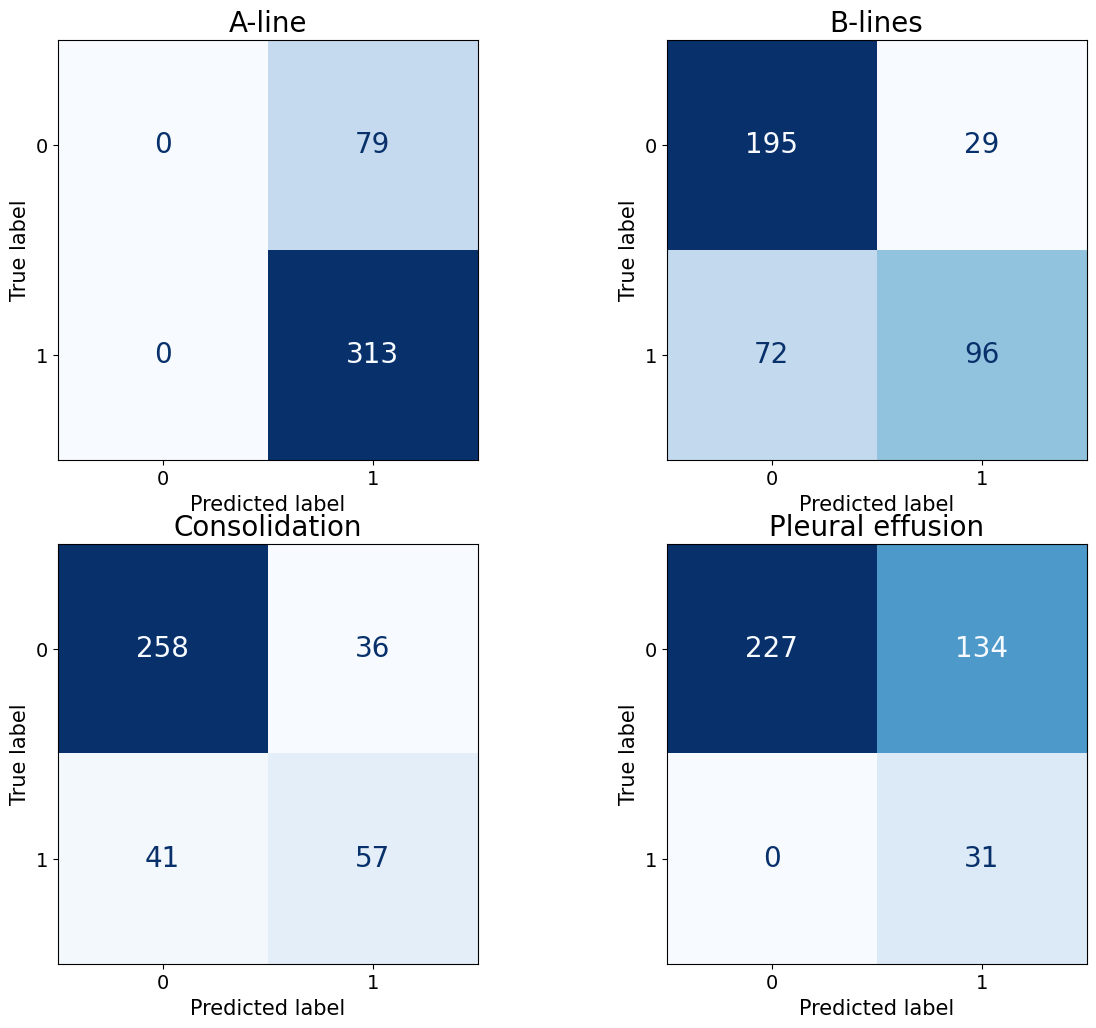

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

confusion_mat = multilabel_confusion_matrix(test_labels, test_preds)

all_labels = [
            'A-line',
#             'B-line',
#             'Confluent B-line',
            'B-lines',
            'Consolidation',
            'Pleural effusion'
            ]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# axs는 2x3 array이므로 axs.flat으로 iterator를 생성합니다.
ax_iterator = iter(axs.flat)

for idx, label in enumerate(all_labels):
    ax = next(ax_iterator)  # 다음 subplot을 가져옵니다.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat[idx], display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)  # 각 subplot에 colorbar를 제거합니다.
    ax.set_title(label, fontsize=20)  # 레이블의 글자 크기를 조정합니다.
    
    # 각 축에 대해 텍스트 크기를 설정합니다.
    ax.set_xlabel('Predicted label', fontsize=15)  # x축 라벨 크기 설정
    ax.set_ylabel('True label', fontsize=15)       # y축 라벨 크기 설정
    ax.tick_params(axis='both', which='major', labelsize=14)  # 축 글자 크기 설정
    
    for texts in [disp.text_]:
        for text in texts.flatten():
            text.set_fontsize(20)  # 숫자 텍스트의 크기를 조정합니다.

# 남는 subplot을 숨깁니다.
for ax in ax_iterator:
    ax.set_visible(False)

plt.show()

In [44]:
# precision_score, recall_score, f1_score 함수를 사용하여 각 레이블별 성능을 계산합니다.
from sklearn.metrics import precision_score, recall_score, f1_score

test_prediction_flat = np.array(test_preds).flatten()
test_labels_flat = np.array(test_labels).flatten()

precision = precision_score(test_labels_flat, test_prediction_flat, average='weighted')
recall = recall_score(test_labels_flat, test_prediction_flat, average='weighted')
f1 = f1_score(test_labels_flat, test_prediction_flat, average='weighted')

print('Micro-averaged precision : ', precision)
print('recall : ', recall)
print('f1-score : ', f1)

Micro-averaged precision :  0.773389742953277
recall :  0.7506377551020408
f1-score :  0.753742527819722


In [45]:
print(classification_report(
    test_labels,
    test_preds,
    output_dict=False,
    target_names=[
            'A-line',
#             'B-line',
#             'Confluent B-line',
            'B-lines',
            'Consolidation',
            'Pleural effusion'
            ]
))

                  precision    recall  f1-score   support

          A-line       0.80      1.00      0.89       313
         B-lines       0.77      0.57      0.66       168
   Consolidation       0.61      0.58      0.60        98
Pleural effusion       0.19      1.00      0.32        31

       micro avg       0.64      0.81      0.72       610
       macro avg       0.59      0.79      0.61       610
    weighted avg       0.73      0.81      0.75       610
     samples avg       0.73      0.81      0.74       610



In [46]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 0], np.array(model_output)[:, 0])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('A-line results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 0] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 0], y_prob_pred, target_names=['A-line', 'Others']))

A-line results
Best Threshold=0.057062, sensitivity = 0.700, specificity = 0.810, J=0.510
              precision    recall  f1-score   support

      A-line       0.41      0.81      0.54        79
      Others       0.94      0.70      0.80       313

    accuracy                           0.72       392
   macro avg       0.67      0.75      0.67       392
weighted avg       0.83      0.72      0.75       392



In [47]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 1], np.array(model_output)[:, 1])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('B-lines results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 1] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 1], y_prob_pred, target_names=['B-line', 'Others']))

B-lines results
Best Threshold=0.370373, sensitivity = 0.893, specificity = 0.701, J=0.594
              precision    recall  f1-score   support

      B-line       0.90      0.70      0.79       224
      Others       0.69      0.89      0.78       168

    accuracy                           0.78       392
   macro avg       0.79      0.80      0.78       392
weighted avg       0.81      0.78      0.78       392



In [48]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 2], np.array(model_output)[:, 2])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
# print('Confluent B-line results')
print('Consolidation')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 2] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 2], y_prob_pred, target_names=['Confluent B-line', 'Others']))

Consolidation
Best Threshold=0.523675, sensitivity = 0.531, specificity = 0.949, J=0.480
                  precision    recall  f1-score   support

Confluent B-line       0.86      0.95      0.90       294
          Others       0.78      0.53      0.63        98

        accuracy                           0.84       392
       macro avg       0.82      0.74      0.77       392
    weighted avg       0.84      0.84      0.83       392



In [49]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 3], np.array(model_output)[:, 3])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Pleural effusion results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_output)[:, 3] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 3], y_prob_pred, target_names=['Pleural effusion', 'Others']))

Pleural effusion results
Best Threshold=0.302738, sensitivity = 0.774, specificity = 0.978, J=0.752
                  precision    recall  f1-score   support

Pleural effusion       0.98      0.98      0.98       361
          Others       0.75      0.77      0.76        31

        accuracy                           0.96       392
       macro avg       0.87      0.88      0.87       392
    weighted avg       0.96      0.96      0.96       392



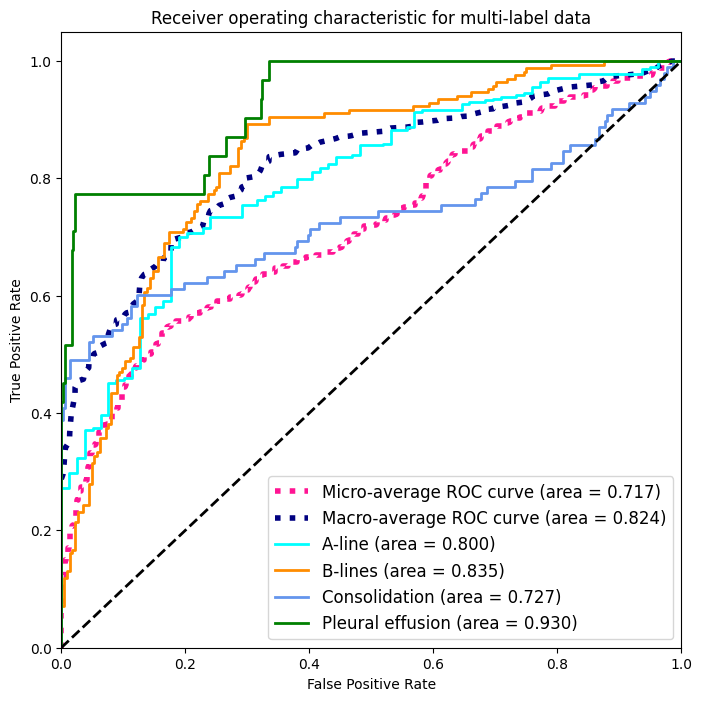

In [50]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc


# ROC curve를 계산하고 시각화합니다.
n_classes = len(test_labels[0])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(test_labels)[:, i], np.array(model_output)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve를 계산합니다.
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(test_labels).ravel(), np.array(model_output).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 모든 레이블에 대한 평균 ROC curve를 계산합니다.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ROC curve를 그래프로 시각화합니다.
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.3f})'
''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.3f})'
''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
all_labels = [
            'A-line',
#             'B-line',
#             'Confluent B-line',
            'B-lines',
            'Consolidation',
            'Pleural effusion'
            ]

for i, label, color in zip(range(len(all_labels)), all_labels, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='{0} (area = {1:0.3f})'
            ''.format(label, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-label data')
plt.legend(loc="lower right", fontsize='large')
plt.show()

In [52]:
if 'imgnet_init_densenet161' in encoder_name:
    models_output_df.to_csv(f'/data2/hoon2/Results/model_output_csv/video_level/temporally_separated_test/densenet_161/{model_output_class}_artifacts_batch{batch_size}_fold_{fold_num}_{model_name}_{head_num}head_{k_size}ksize_output.csv', index = False)
elif 'densenet161_scratch' in encoder_name:
    models_output_df.to_csv(f'/data2/hoon2/Results/model_output_csv/video_level/temporally_separated_test/densenet_161/{model_output_class}_artifacts_batch{batch_size}_fold_{fold_num}_{model_name}_{head_num}head_{k_size}ksize_output_scratch.csv', index = False)

In [ ]:
# models_output_df.to_csv(f'/data2/hoon2/Results/model_output_csv/video_level/temporally_separated_test/resnet_50/{model_output_class}_artifacts_batch{batch_size}_fold_{fold_num}_{model_name}_{head_num}head_{k_size}ksize_output.csv', index = False)

In [109]:
# models_output_df.to_csv(f'/home/work/LUS/Results/model_output_csv/video_level/temporally_separated_test/densenet_161/{model_output_class}_artifacts_batch{batch_size}_fold_{fold_num}_{model_name}_{model_version}_{head_num}head_{k_size}ksize_output.csv', index = False)

In [110]:
def gt_to_dataframe(df, labels, model_output):
    """
    모델 출력을 기존 데이터프레임에 추가하는 함수
    """
    temp_df = pd.DataFrame(model_output, columns=labels)
    temp_df.columns = [f'{label}' for label in labels]
    
    if df.empty:
        return temp_df
    else:
        return pd.concat([df, temp_df], axis=1)

In [ ]:
labels = ['clip_id', 'A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

models_gt_df = pd.DataFrame(columns=labels)

models_gt_df = gt_to_dataframe(models_gt_df, labels, test_labels)
models_gt_df.head()

,A-line,total-B-line,Consolidation,Pleural effusion
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [112]:
models_gt_df.to_csv(f'/data2/hoon2/Results/model_output_csv/video_level/temporally_separated_test/resnet_50/{model_output_class}_artifacts_fold_{fold_num}_video_level_gt.csv', index = False)

In [113]:
# models_gt_df.to_csv(f'/home/work/LUS/Results/model_output_csv/video_level/temporally_separated_test/densenet_161/{model_output_class}_artifacts_fold_{fold_num}_video_level_gt.csv', index = False)

In [73]:
models_gt_df

,A-line,total-B-line,Consolidation,Pleural effusion
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
387,1.0,0.0,1.0,0.0
388,1.0,0.0,1.0,0.0
389,1.0,0.0,1.0,0.0
390,1.0,0.0,1.0,0.0


# 신뢰 구간

In [132]:
from scipy.stats import norm
from compare_auc_delong import *

def delong_auc_ci(y_true, y_pred, alpha=0.95):
    """
    DeLong 방법을 이용하여 AUC와 95% 신뢰 구간 계산
    Args:
    - y_true: 실제 레이블 값 (0과 1로 구성된 numpy 배열)
    - y_pred: 예측 확률값 (numpy 배열)
    - alpha: 신뢰수준 (기본값 0.95)

    Returns:
    - auc: AUC 값
    - ci: AUC에 대한 신뢰 구간 (하한, 상한)
    """
    auc, auc_var = delong_roc_variance(y_true, y_pred)
    auc_std = np.sqrt(auc_var)

    # 신뢰 구간 계산
    lower_upper_q = np.array([0.5 - alpha / 2, 0.5 + alpha / 2])
    ci = norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    
    # 신뢰 구간의 범위를 0과 1 사이로 조정
    ci[ci < 0] = 0
    ci[ci > 1] = 1

    return auc, ci

In [133]:
def cal_CI(gt_df, method_df):
    CI_values = {}
    auc_values = {}
    for idx in range(len(labels)):
        gt_series = gt_df.iloc[:, idx]
        method__series = method_df.iloc[:, idx]
        
        auc, ci = delong_auc_ci(gt_series, method__series)
        
        CI_values[labels[idx]] = ci
        auc_values[labels[idx]] = auc.item()
        
    return CI_values, auc_values

In [134]:
CIs, AUCs = cal_CI(models_gt_df, models_output_df)

results = {
    'Label': list(AUCs.keys()),
    'AUC': list(AUCs.values()),
    '95% CI Lower Bound': [ci[0] for ci in CIs.values()],
    '95% CI Upper Bound': [ci[1] for ci in CIs.values()]
}
results_df = pd.DataFrame(results)
results_df

,Label,AUC,95% CI Lower Bound,95% CI Upper Bound
0,A-line,0.771020,0.724528,0.817511
1,total-B-line,0.861607,0.824537,0.898677
2,Consolidation,0.781098,0.728036,0.834161
3,Pleural effusion,0.883835,0.806764,0.960907


In [135]:
models_output_df

,LUVM_A-line,LUVM_total-B-line,LUVM_Consolidation,LUVM_Pleural effusion
0,0.983499,0.037017,0.007439,0.009947
1,0.982922,0.033386,0.008662,0.011939
2,0.989784,0.022246,0.008060,0.007943
3,0.977877,0.050286,0.009173,0.009220
4,0.976240,0.046818,0.010732,0.011150
...,...,...,...,...
387,0.007818,0.954691,0.026550,0.001065
388,0.008409,0.937661,0.028108,0.000966
389,0.007835,0.924595,0.034383,0.001493
390,0.008762,0.931340,0.031018,0.001127


# grad-cam

In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [22]:
def collate_video(batch_list):
    """
    A custom collate function to be passed to the callate_fn argument when creating a pytorch dataloader.
    This is necessary because videos have different lengths. We handle by combining all videos along the time 
    dimension and returning the number of frames in each video.
    """
    vids = torch.concat([b[0] for b in batch_list])
    # num_frames = [b.shape[0] for b in batch_list]
    labels = [b[1] for b in batch_list]
    paths = [b[2] for b in batch_list]

    return vids, labels, paths

In [23]:
# dataset
video_batch_size = 4

test_csv_path = os.path.join(base_path, f'clip/{model_output_class}_artifacts/temporally_separated_test.csv')
test_df = pd.read_csv(test_csv_path)
# dataset
test_dataset = video_dataset(test_csv_path, transforms = apply_transforms(mode=None), img_size = img_size, is_train = False)

# dataloader
test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle = False, collate_fn=collate_video, drop_last=False)

#len_dataloader
len_test_dataset = len(test_dataloader.dataset)
print(len_test_dataset)
# set seed
set_all_seeds(1234)

encoder = timm.create_model('densenet161', pretrained=False, num_classes=0)

392


In [ ]:
LABEL_INT2STR = {0:'A-line', 
                     1:'B-lines',
                     2:'Consolidation',
                     3:'Pleural effusion'}

sigmoid = nn.Sigmoid()

# Set up model
num_frames = [30]*batch_size
num_heads = 8
kernel_size = 13

model = LUV_Net(encoder, num_heads, pooling_method = pooling_method, kernel_width= kernel_size)

gpu_index = 1
device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

check_point = torch.load(weight_path, map_location=device)
# torch.nn.DataParallel을 사용하여 모델을 학습하고 저장한 경우에 이러한 접두어가 자주 발생
if 'module' in list(check_point['model'].keys())[0]:
    # If so, remove the 'module.' prefix from the keys in the state_dict
    new_state_dict = {k[7:]: v for k, v in check_point['model'].items()}
    model.load_state_dict(new_state_dict)
else:
    # If not using DataParallel, simply load the state_dict
    model.load_state_dict(check_point['model'])

model = model.to(device)

# load best threshold
best_val_thres = check_point['best_valid_thres']
print(best_val_thres)

model2 = model.encoder

layer = model2.features[-1]
cam = GradCAM(model=model2, target_layers=[layer])
    
model.eval() 
with torch.no_grad():    
    for data in tqdm(test_dataloader, desc="Testing", unit="batch"):    
        test_img, test_label, path = data
#             print(test_img.shape)
        test_img = test_img.float().to(device)

#             print(test_img.shape)
        test_output, attentions = model(test_img, num_frames)
#             print(test_output)
        test_output = sigmoid(test_output)

        test_preds_np = test_output[0].data.cpu().numpy()

        test_preds_np = np.where(test_preds_np >= best_val_thres, 1, 0)

        np_test_label = test_label[0].cpu().numpy()
        
        ################################################## 
        # Grad=-cam
    #             print(rgb_vid.shape)
    #             print(test_vid.shape)
        rgb_vid = load_video(path[0])
        cam_results = []
        test_img_copy = test_img.clone()
        
        for frame_idx in range(rgb_vid.shape[0]):
            
            img = test_img_copy[frame_idx].unsqueeze(0).to(device)

    #             print(rgb_vid[frame_idx].shape)
            rgb_img = rgb_vid[frame_idx]
            rgb_img = np.float32(rgb_img) / 255

            with torch.enable_grad():  # 그래디언트 계산 활성화
                grayscale_cam = cam(input_tensor=img, aug_smooth=True, eigen_smooth=False)
            grayscale_cam = grayscale_cam[0, :]
            cam_result = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
            cam_results.append(cam_result)
                
#         print(path[0].split('/')[-1].split('.')[0])
#         print(f"prediction : {test_preds_np}, test_label : {np_test_label}")
        
        label_idx = np.where(np_test_label == 1)[0]
        labels_lst = [LABEL_INT2STR[idx] for idx in label_idx]

        all_labels = ' , '.join(labels_lst)

        label_str = ', '.join(np_test_label.astype(int).astype(str))
        test_preds_str = ', '.join(test_preds_np.astype(int).astype(str))

        patient_id = path[0].split('/')[-1].split('.')[0]
        patient_id2 = patient_id.rsplit('_', 2)[0]
        file_name = f"{patient_id}_true[{label_str}]_pred[{test_preds_str}]"

        # Save only the cam_result image
        vid_cam_result_output_dir = f'/home/work/LUS/Results/Grad_CAM/video_level/{model_name}_{model_version}_{video_batch_size}batch_{encoder_name}_{num_heads}head_{k_size}ksize_fold{fold_num}/video_cam_TP/{patient_id2}'
        if not os.path.exists(vid_cam_result_output_dir):
            os.makedirs(vid_cam_result_output_dir)
#         print(file_name)
        fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
        video_filename = f'{vid_cam_result_output_dir}/{file_name}.avi'
        out = cv2.VideoWriter(video_filename, fourcc, 30, (256, 256))
#         print(len(cam_results))
#         print(cam_results[0].shape)
        for frame in cam_results:
            bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(bgr_frame)  # Write each frame
        out.release()

[0.2747937, 0.28761905, 0.22301994, 0.054686785]


Testing: 100% 392/392 [1:53:24<00:00, 17.36s/batch]
